**Problem 1:** *Capacitated facility location.* 

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the attached script to generate the data, and to visualize the results. You are supposed to play with different configurations and sizes of the problem. Please make your report detailed (otherwise lower amount of points then indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

Below is the solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code. 

Optimize a model with 50 rows, 315 columns and 645 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 4e+00]
  Objective range [2e-04, 5e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 33.3461
Presolve time: 0.00s
Presolved: 50 rows, 315 columns, 645 nonzeros
Variable types: 0 continuous, 315 integer (315 binary)

Root relaxation: objective 6.503730e+00, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.50373    0   12   33.34610    6.50373  80.5%     -    0s
H    0     0                      11.5023502    6.50373  43.5%     -    0s
H    0     0                       8.1447511    6.50373  20.1%     -    0s
     0     0    6.86502    0   26    8.14475    6.86502  15.7%     -    0s
H    0     0                       7.9698679    6.86502  13.9%     -    0s
     0     0    7.157

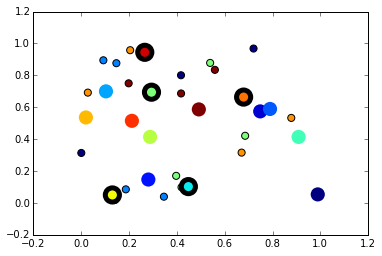

In [1]:
from gurobipy import *

import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

C = 20; # number of clients
clients = np.random.rand(2,C); #client positions
F = 15; #number of facilities
facilities = np.random.rand(2,F);

capacities = np.ones((F,))*4; #maximum number of clients per facility

dx = np.matlib.repmat(clients[0,:],F,1) - np.matlib.repmat(facilities[0,:],C,1).transpose();
dy = np.matlib.repmat(clients[1,:],F,1) - np.matlib.repmat(facilities[1,:],C,1).transpose();

assignment_costs = 3*(dx*dx + dy*dy); #the assignment cost is the distance squared

opening_costs = np.ones((F,));

# create the model
m = Model("facility")

y = []
for i_f in range(F):
    y.append(m.addVar(vtype=GRB.BINARY))

x = []    
for i_f in range(F):
    x.append([])
    for i_c in range(C):
        x[i_f].append(m.addVar(vtype=GRB.BINARY))

# the objective is to minimize the total fixed and variable costs
m.modelSense = GRB.MINIMIZE

# update model to integrate new variables
m.update()

# set optimization objective - minimize sum of fixed costs
obj_summands = []
for i_f in range(F):
    obj_summands.append(opening_costs[i_f]*y[i_f])
    
for i_f in range(F):
    for i_c in range(C):
        obj_summands.append(assignment_costs[i_f][i_c]*x[i_f][i_c])

m.setObjective(quicksum(obj_summands))  

# set constraints
for i_c in range(C):
    client_constr_summands = [x[i_f][i_c] for i_f in range(F)]
    m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)
        
for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(sum(facility_constr_summands), GRB.LESS_EQUAL, capacities[i_f]*y[i_f])       

for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(max(facility_constr_summands), GRB.LESS_EQUAL, y[i_f])     

# optimize
  
m.optimize()

# plot the solution
facilities_opened = [y[i_f].X for i_f in range(F)]    
clients_assignment = [i_f for i_f in range(F) for i_c in range(C) if x[i_f][i_c].X != 0]
    
plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened])
plt.show()


** Problem 2 **: *Optimal vehicle speed scheduling (6 points) *-- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of *n* segments, between *n + 1* waypoints labeled *0, . . . , n*. Segment *i* starts at waypoint *i − 1* and terminates at waypoint *i*. The vehicle starts at time *t = 0* at waypoint *0*. It travels over each segment at a constant (nonnegative) speed; *si* is the speed on segment *i*. We have lower and upper limits on the speeds: *smin ≤ s ≤ smax*. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment *i* is *di* (which is positive), so the travel time over segment *i* is *di/si*. We let *τi*, *i = 1, . . . , n,* denote the time at which the vehicle arrives at waypoint *i*. The vehicle is required to arrive at waypoint *i*, *for i = 1, . . . , n*, between times *τmin,i* and *τmax,i* , which are given. The vehicle consumes fuel over segment *i* at a rate that depends on its speed *Φ(s_i )=a s_i^2+b s_i+c kg/s*.

You are given the data *d* (segment travel distances), *smin* and *smax* (speed bounds), *τmin* and *τmax* (waypoint arrival time bounds), and the the parameters *a*, *b*, and *c* (all parameters are in *veh_speed_sched_data.m*). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command *step* to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough. **NB**: later in the course we will get back to this problem and attack it with a different method.


In [6]:
import scipy.io as sio

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a']
b = mat_contents['b']
c = mat_contents['c']
d = mat_contents['d']
n = mat_contents['n']
smin = mat_contents['smin']
smax = mat_contents['smax']
tau_min = mat_contents['tau_min']
tau_max = mat_contents['tau_max']
